# Behavioral Cloning for Autonomous Vehicles - Prediction

Ignore warnings.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Dependencies

Import libraries.

In [2]:
import os
import ntpath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

## Read Driving Log

Import and read `Driving-Log.csv`.

In [3]:
def shorten_path(path):
    '''
    Function to view shortened paths.
    '''
    head,tail = ntpath.split(path)
    return tail

In [4]:
# Define data directory
data_directory = 'Dataset'

# Read the driving log
headers = ['Center Frame', 'Left Frame', 'Right Frame', 'Steering Angle', 'Throttle', 'Brake','Speed']
driving_log = pd.read_csv(os.path.join(data_directory,'Driving-Log.csv'), names = headers)
pd.set_option('display.max_colwidth', -1)

# Shorthen the paths
driving_log['Center Frame'] = driving_log['Center Frame'].apply(shorten_path)
driving_log['Left Frame'] = driving_log['Left Frame'].apply(shorten_path)
driving_log['Right Frame'] = driving_log['Right Frame'].apply(shorten_path)

# View the first 5 entries in the dataframe
driving_log.head()

,Center Frame,Left Frame,Right Frame,Steering Angle,Throttle,Brake,Speed
0,Center_Frame_2019_08_10_18_29_45_626.jpg,Left_Frame_2019_08_10_18_29_45_626.jpg,Right_Frame_2019_08_10_18_29_45_626.jpg,0.0,0.4,0,2.760634
1,Center_Frame_2019_08_10_18_29_45_692.jpg,Left_Frame_2019_08_10_18_29_45_692.jpg,Right_Frame_2019_08_10_18_29_45_692.jpg,0.0,0.4,0,3.024059
2,Center_Frame_2019_08_10_18_29_45_763.jpg,Left_Frame_2019_08_10_18_29_45_763.jpg,Right_Frame_2019_08_10_18_29_45_763.jpg,0.0,0.4,0,3.388839
3,Center_Frame_2019_08_10_18_29_45_832.jpg,Left_Frame_2019_08_10_18_29_45_832.jpg,Right_Frame_2019_08_10_18_29_45_832.jpg,0.0,0.4,0,3.676442
4,Center_Frame_2019_08_10_18_29_45_901.jpg,Left_Frame_2019_08_10_18_29_45_901.jpg,Right_Frame_2019_08_10_18_29_45_901.jpg,0.0,0.4,0,4.031865


## Load Data

Load data for ~1 lap.

In [5]:
def load_data(data_directory, dataframe, count):
    '''
    Loads `steering_angles` from `dataframe` and `frames` as paths to center frames
    by preceeding center frame names from `dataframe` by `data_directory`. The
    `count` parameter is essentially the number of frames for ~1 lap.
    
    Note: `frames[i]` can be modified later to define path to left or right frames.
    '''
    frame = []
    steering_angle = []
    for i in range(count): # For ~1 lap
        indexed_data = dataframe.iloc[i]
        frame.append(os.path.join(data_directory, indexed_data[0].strip())) # Load only center frame paths
        steering_angle.append(float(indexed_data[3])) # Load steering angles
    frames = np.asarray(frame)
    steering_angles = np.asarray(steering_angle)
    return frames, steering_angles

In [6]:
# Load data
frames, steering_angles = load_data(data_directory+'/Camera-Frames', driving_log, 1200)

In [7]:
# Free up memory by nullifying `driving_log`
driving_log = None

## Data Preprocessing

Define and test the preprocessing pipeline.

In [8]:
def data_preprocessor(image):
    '''
    Preprocesses the input `image` by applying a series of image processing techniques.
    '''
    image = cv2.resize(image, (200, 66)) # Resize the image to the input shape used by the neural network
    image = (image/255.0)-0.5 # Normalization and mean centering
    return image

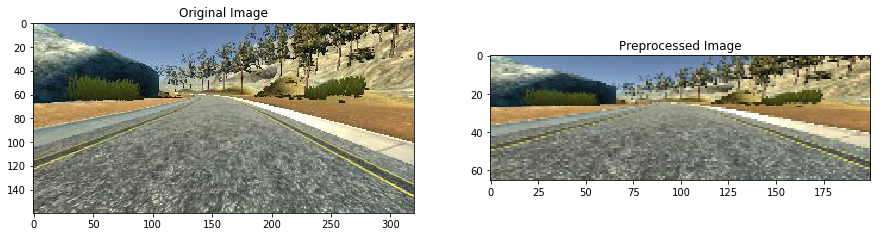

In [9]:
# Test `data_preprocessor()` on a random image
image = frames[random.randint(0, len(frames)-1)]
original_image = mpimg.imread(image)
preprocessed_image = data_preprocessor(original_image)

# Visualize the original and preprocessed images side-by-side
figure, axes = plt.subplots(1, 2, figsize = (15, 10))
figure.tight_layout
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image+0.5) # Add 0.5 to clip RGB image data to the valid range for imshow ([0..1] for floats or [0..255] for integers) - only for visualization
axes[1].set_title('Preprocessed Image')
plt.show()

## Load the Trained Model

Load the pre-trained model and generate a brief summary (sanity check).

In [10]:
model = load_model('Our_Simplistic_Driving_Behaviour_Model.h5')
print(model.summary()) # Sanity check

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 31, 98, 24)        1824      
_________________________________________________________________
CONV2 (Conv2D)               (None, 14, 47, 36)        21636     
_________________________________________________________________
CONV3 (Conv2D)               (None, 5, 22, 48)         43248     
_________________________________________________________________
CONV4 (Conv2D)               (None, 3, 20, 64)         27712     
________________________________

## Visualize Filters

Visualize the filters from the three convolutional layers.

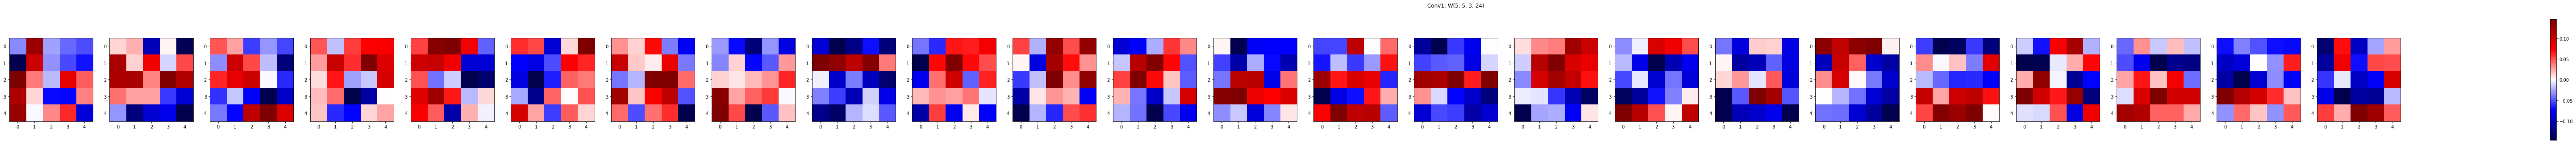

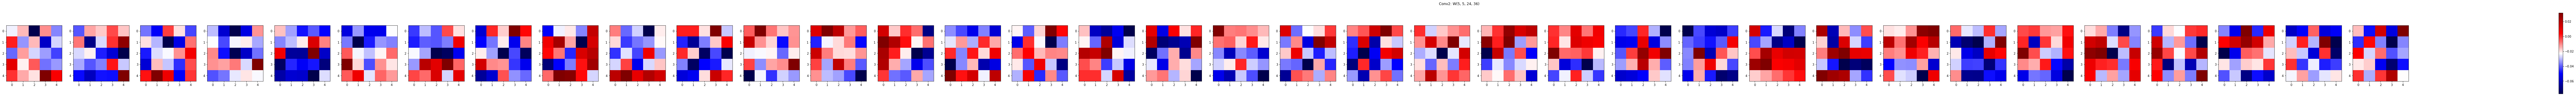

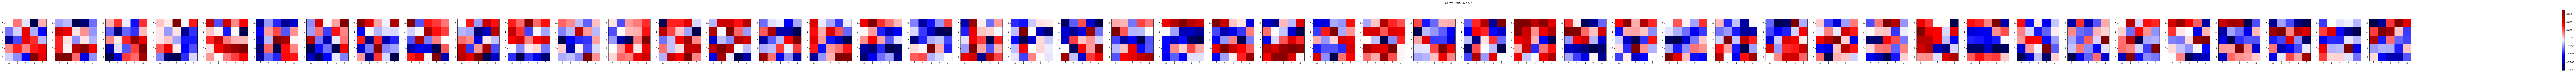

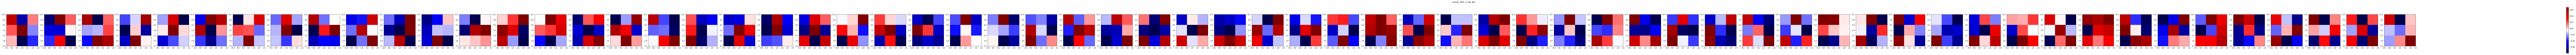

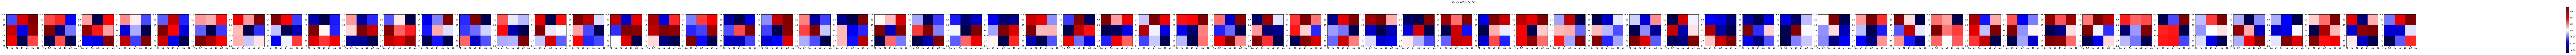

In [11]:
for layer_idx in [0, 1, 2, 3, 4]: # Define indices of convolutional layers
    weights = np.array(model.layers[layer_idx].get_weights())[0] # Get the trained weights
    figure, axes = plt.subplots(1, weights.shape[3], figsize = (5*weights.shape[3], 5)) # Set figure size
    for kernel_idx in range(weights.shape[3]): # Loop through all the filters
        kernel = weights[:,:,0,kernel_idx] # Get the filter
        kernel = axes[kernel_idx].imshow(kernel, cmap='seismic', interpolation='none') # Plot the filter
    figure.suptitle('Conv{}: W{}'.format(layer_idx+1, weights.shape)) # Set figure title [Format: Conv<layer_idx+1>: W(<height>, <width>, <depth>, <number>)]
    figure.colorbar(kernel, ax=axes, cmap='seismic') # Generate a color bar for cross-referencing filter values
plt.show() # Show the figure

## Visualize Activation Maps

Visualize the activation maps of the three convolutional layers.

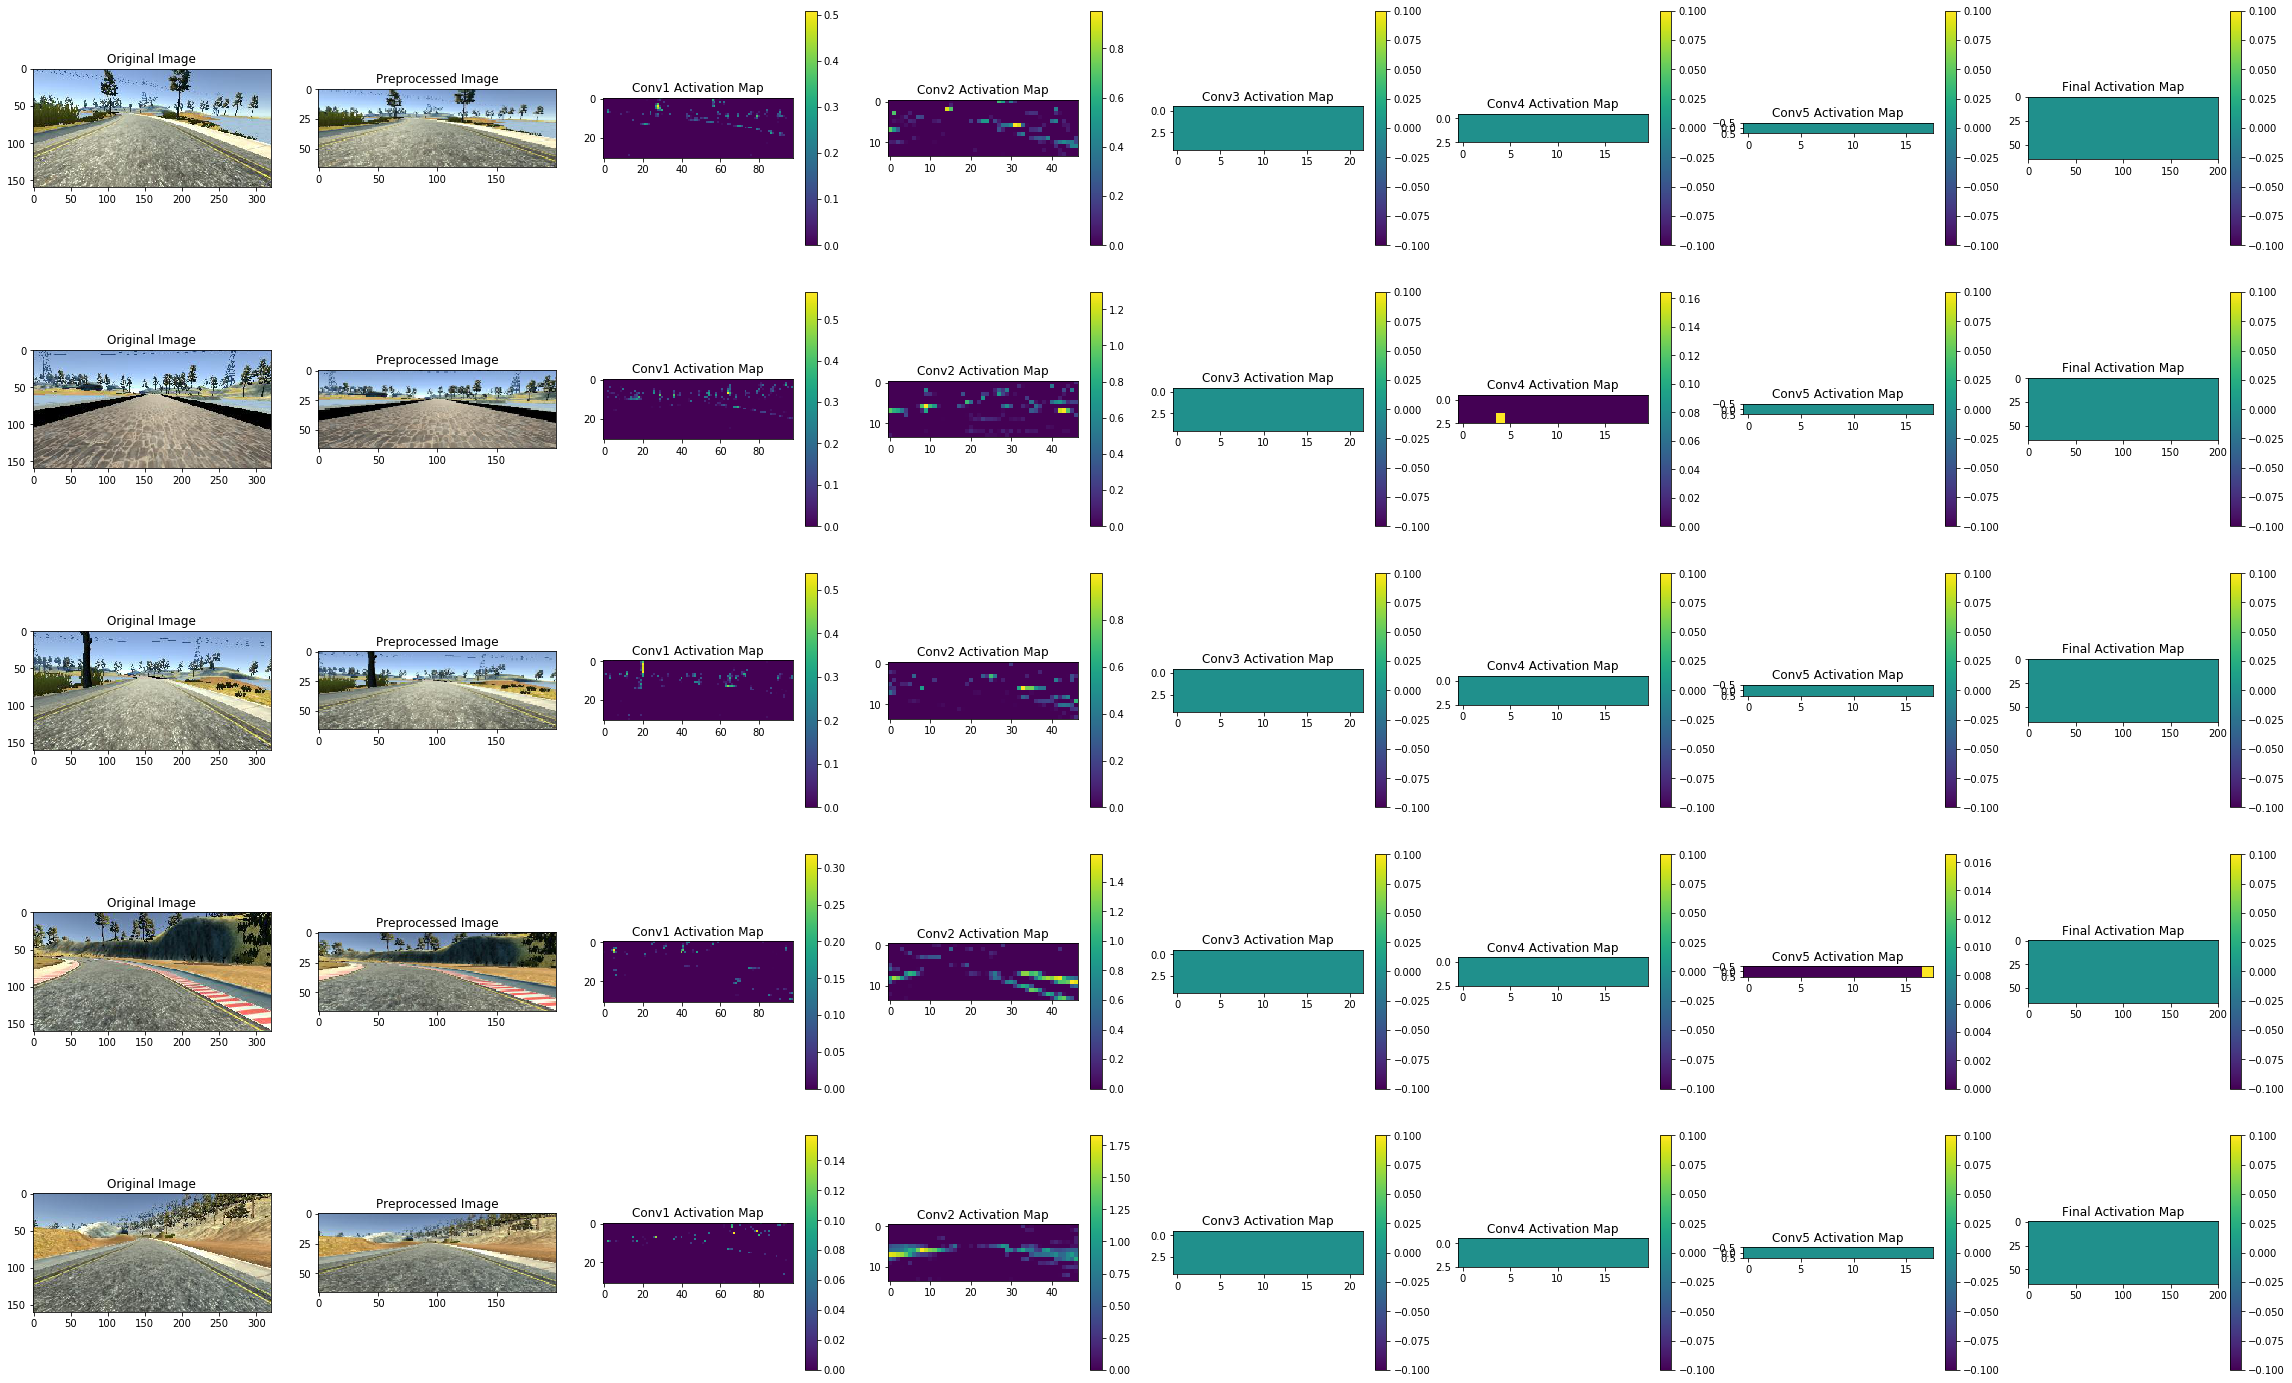

In [12]:
conv_layer_idx = [0, 1, 2, 3, 4] # Define indices of convolutional layers
conv_layer_count = len(conv_layer_idx) # Number of convolutional layers
img_count = 5 # Number of test images

figure, axes = plt.subplots(img_count, conv_layer_count+3, figsize = (40, 25)) # Set figure size

for i in range(img_count): # Loop through all test images
    image = frames[random.randint(0, len(frames)-1)] # Get a random frame
    image = mpimg.imread(image) # Read the image
    axes[i,0].imshow(image) # Show original image
    axes[i,0].set_title('Original Image') # Set title for original image
    preprocessed_image = data_preprocessor(image) # Preprocess the image
    (height, width) = preprocessed_image.shape[0:2] # Get dimensions of preprocessed image (to be used later)
    axes[i,1].imshow(preprocessed_image+0.5) # Show the preprocessed image
    axes[i,1].set_title('Preprocessed Image') # Set title for preprocessed image
    j = 2 # Define counter to denote further row numbers
    activations = [] # Empty list to hold activation maps of all convolutional layers
    for layer_idx in conv_layer_idx: # Loop through all the convolutional layers
        get_layer_output = K.function([model.layers[0].input], [model.layers[layer_idx].output]) # Define activation map
        layer_output = get_layer_output(np.array([preprocessed_image]))[0] # Get the activation map
        activation_map = axes[i,j].imshow(layer_output[0,:,:,0]) # Show the activation map
        figure.colorbar(activation_map, ax=axes[i,j], cmap='heatmap') # Generate a color bar for cross-referencing activation values
        axes[i,j].set_title('Conv{} Activation Map'.format(layer_idx+1)) # Set title for the activation map
        activations.append(layer_output[0,:,:,0]) # Append the current activation map to the list
        j += 1 # Update row counter
    for k in range(conv_layer_count-1): # This loop is an algorithm to project the activations back on the preprocessed image
        (h,w) = activations[k].shape # Get dimensions of current activation map
        activations[k+1] = cv2.resize(activations[k+1], (w,h)) # Resize the next activation map to the size of previous one
        activations[k+1] = activations[k+1]*activations[k] # Multiply the current and next activation maps (element-wise multiplication)
    activation_image = cv2.resize(activations[-1], (width,height)) # Resize the very first activation map (updated by the algorithm earlier) to the size of preprocessed image
    activation_image = axes[i,j].imshow(activation_image) # Show the activation image
    figure.colorbar(activation_image, ax=axes[i,j], cmap='heatmap') # Generate a color bar for cross-referencing activation values
    axes[i,j].set_title('Final Activation Map') # Set title for activation image
plt.show() # Show the figure

## Visualize Predictions

Make the trained model predict steering angles by sequentially showing it frames for ~1 lap and compare these predictions against the ground truth.

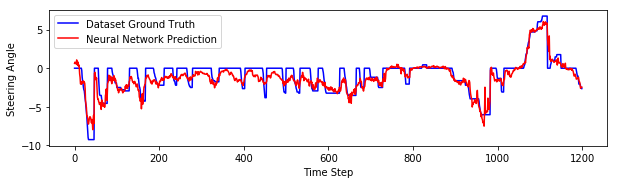

In [13]:
true_steering_angle = [] # Empty list to store true steering angles
predicted_steering_angle = [] # Empty list to store predicted steering angles

for i in range(1200): # For ~1 lap
    image = frames[i] # Get frame path
    image = mpimg.imread(image) # Read the frame
    image = data_preprocessor(image) # Preprocess the frame
    image = np.array([image]) # Convert to 4D array (the model expects 4D array)
    true_steering_angle.append(steering_angles[i]) # True steering angle
    predicted_steering_angle.append(float(model.predict(image))) # Predict steering angle for the current frame
true_steering_angles = np.asarray(true_steering_angle) * 25 # List of true steering angles
predicted_steering_angles = np.asarray(predicted_steering_angle) * 25 # List of predicted steering angles

time_step = list(range(1200)) # Time steps for ~1 lap

# Plot the results
plt.figure(figsize = (10,2.5))
plt.plot(time_step, true_steering_angles, 'b', label='Dataset Ground Truth')
plt.plot(time_step, predicted_steering_angles, 'r', label='Neural Network Prediction')
plt.legend(loc='upper left')
plt.xlabel('Time Step')
plt.ylabel('Steering Angle')
plt.show()